# Infer failure probability

### Available features
Weather features : 
- PRCP : Precipitation (tenths of mm)
- SNOW : Snowfall (mm)
- SNWD : Snow depth (mm)
- TAVG : Average daily temperature (tenths of degrees C)
- TMIN : Minimum temperature (tenths of degrees C)
- TMAX : Maximum temperature (tenths of degrees C)
- ASTP : Average Station Level Pressure for the day (hPa * 10)
- AWND : Average daily wind speed (tenths of meters per second)
- FRGB : Base of frozen ground layer (cm)
- FRTH : Top of frozen ground layer (cm)
- GAHT : Difference between river and gauge height (cm)
- WSF1 : Fastest 1-minute wind speed (tenths of meters per second)

Load features :
(everyting is unitless, as we took the time series for each states that we have then normalized by the historical maximum value)
- PAVG : Daily load average
- PMIN : Daily load minimum
- PMAX : Daily load maximum
- PDMMAX : Daily hour to hour maximum load change
- PFMAX : Daily hourly maximum signed difference between real and forecasted power load (positive if real > forecast)

Temporal features :
- Season : Winter (0), Spring (1), Summer (2), Fall (3)
- 

Geographical features :
- State : US state or Canadian province name

### Targets to predict
- **'CauseCodeCluster'** : Predict a failure type. Since there are too many cause codes (> 1,000) we first clusterize the cause codes using kmeans on the features and then predict the cause code cluster
- **'Frequency'** : Predict the failure frequency
- **'1-Frequency'** : Predict the "surviving" frequency, i.e 1-Failure frequency. THis is useful for using loss function that evaluate relative gaps such as MAPE

### Evaluation Metric
- RMSE
- MAE
- MAPE

In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im

importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

## Import data

In [2]:
weather_data_file = '../DATA/weather_data_per_state_all.csv'
power_load_file = '../DATA/power_load_input.csv'
weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
power_load_data = pd.read_csv(power_load_file, index_col=[0,1], parse_dates=[0])


# features_names=['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMIN', 'TMAX', 'ASTP', 'AWND', 
#                 'PAVG', 'PMIN', 'PMAX', 'PDMAX',
#                 'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(weather_data.columns) + list(power_load_data.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(set(features_names)-set(['EventStartDT', 'Date']))


/var/folders/01/r5kd5w_d2g3f08450t2g_p5h0000gn/T/ipykernel_63209/1390343619.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
/var/folders/01/r5kd5w_d2g3f08450t2g_p5h0000gn/T/ipykernel_63209/1390343619.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])


In [3]:
merged_count_df, feature_names, target_columns = im.preprocess_data(failure_path='../DATA/filtered_events.csv',
                                                                event_count_path='../DATA/event_count.csv',
                                                                weather_data_path=weather_data_file,
                                                                power_data_path=power_load_file,
                                                                feature_names=features_names,
                                                                target='Unit_Failure',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=True,
                                                                cyclic_features=['Season', 'Month', 'DayOfWeek', 'DayOfYear'],
                                                                cause_code_n_clusters=1,
                                                                feature_na_drop_threshold=0.10)

stand_cols = [f for f in feature_names if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]

print(f"Features : {feature_names}")
print(f"Targets : {target_columns}")
print(f"Dataset shape: {merged_count_df.shape}")
merged_count_df.head()

Dropping weather columns with >10.0% NaN: ['ADPT', 'ASLP', 'ASTP', 'AWND', 'EVAP', 'HeatIndex', 'RHAV', 'RHMN', 'RHMX', 'StormSeverity', 'THIC', 'TSUN', 'WESD', 'WESF', 'WSFG', 'WindChill']
Features : ['TMAX', 'Holiday', 'PDMAX', 'ExtremeWind', 'HDD', 'Weekend', 'HDD_7d', 'PAVG', 'SNOW', 'SNWD', 'PMIN', 'PRCP_30d_sum', 'SnowSeverity', 'FDD', 'PRCP', 'PRCP_30dz', 'TAVG', 'CDD_7d', 'TMIN', 'FDD_7d', 'ExtremeCold', 'PMAX', 'CDD', 'ExtremeHeat', 'State_ALABAMA', 'State_ALBERTA', 'State_ARIZONA', 'State_ARKANSAS', 'State_BRITISH COLUMBIA', 'State_CALIFORNIA', 'State_COLORADO', 'State_FLORIDA', 'State_GEORGIA', 'State_IDAHO', 'State_INDIANA', 'State_IOWA', 'State_KANSAS', 'State_KENTUCKY', 'State_LOUISIANA', 'State_MAINE', 'State_MARYLAND', 'State_MASSACHUSETTS', 'State_MICHIGAN', 'State_MINNESOTA', 'State_MISSISSIPPI', 'State_MISSOURI', 'State_MONTANA', 'State_NEBRASKA', 'State_NEVADA', 'State_NEW BRUNSWICK', 'State_NEW HAMPSHIRE', 'State_NEW JERSEY', 'State_NEW MEXICO', 'State_NEW YORK', '

,TMAX,Holiday,PDMAX,ExtremeWind,HDD,Weekend,HDD_7d,PAVG,SNOW,SNWD,...,Season_sin,Season_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,C_0,Data_weight
0,0.081279,1.0,0.037133,0.0,21.433333,0.0,221.422222,0.743598,0.769231,203.898551,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
1,-7.209868,1.0,0.051583,0.0,31.914286,0.0,210.123810,0.572934,10.568421,188.787879,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
2,-7.209868,1.0,0.051583,0.0,31.914286,0.0,210.123810,0.572934,10.568421,188.787879,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
3,-7.209868,1.0,0.051583,0.0,31.914286,0.0,210.123810,0.572934,10.568421,188.787879,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
4,-7.209868,1.0,0.051583,0.0,31.914286,0.0,210.123810,0.572934,10.568421,188.787879,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0


In [3]:
merged_freq_df, feature_names_freq, target_columns_freq = im.preprocess_data(failure_path='../DATA/filtered_events.csv',
                                                                event_count_path='../DATA/event_count.csv',
                                                                weather_data_path=weather_data_file,
                                                                power_data_path=power_load_file,
                                                                feature_names=features_names,
                                                                target='Frequency',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=True,
                                                                cyclic_features=['Season', 'Month', 'DayOfWeek', 'DayOfYear'],
                                                                cause_code_n_clusters=1,
                                                                feature_na_drop_threshold=0.10)

stand_cols_freq = [f for f in feature_names_freq if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]
print(f"Dataset shape: {merged_freq_df.shape}")
merged_freq_df.head()

Dropping weather columns with >10.0% NaN: ['ADPT', 'ASLP', 'ASTP', 'AWND', 'EVAP', 'HeatIndex', 'RHAV', 'RHMN', 'RHMX', 'StormSeverity', 'THIC', 'TSUN', 'WESD', 'WESF', 'WSFG', 'WindChill']
Dataset shape: (135594, 81)


,FDD,TMIN,FDD_7d,CDD_7d,PAVG,HDD,HDD_7d,Holiday,PRCP_30d_sum,PMAX,...,Season_sin,Season_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,C_0,Data_weight
0,3.433333,-8.641475,95.422222,0.0,0.743598,21.433333,221.422222,1.0,15.471076,0.822241,...,-2.449294e-16,1.0,0.0,1.0,8.660254e-01,0.5,0.000000,1.000000,0.0,1.0
1,13.914286,-16.364189,84.123810,0.0,0.572934,31.914286,210.123810,1.0,59.968034,0.680022,...,-2.449294e-16,1.0,0.0,1.0,8.660254e-01,0.5,0.000000,1.000000,0.0,7.0
2,7.811111,-13.800885,81.355556,0.0,0.790852,25.811111,207.355556,0.0,14.840813,0.878699,...,-2.449294e-16,1.0,0.0,1.0,8.660254e-01,-0.5,0.017213,0.999852,0.0,1.0
3,15.428571,-15.945223,86.642857,0.0,0.649519,33.428571,212.642857,0.0,59.486937,0.766969,...,-2.449294e-16,1.0,0.0,1.0,8.660254e-01,-0.5,0.017213,0.999852,0.0,7.0
4,6.544444,-10.945536,68.711111,0.0,0.787478,24.544444,194.711111,0.0,14.356604,0.866494,...,-2.449294e-16,1.0,0.0,1.0,1.224647e-16,-1.0,0.034422,0.999407,0.0,1.0


# Frequency prediction

## XGBoost

In [40]:
importlib.reload(im)

xgb_model = im.xgboostModel(verbose=True)
xgb_model.build_model(max_depth=6,
                      eta=0.07,
                      gamma=0.8,
                      reg_lambda=1,
                      num_boost_round=100,
                      feature_cols=feature_names_freq,
                      target_cols=target_columns_freq,
                      eval_metric='logloss', # rmse, logloss, mae, mape
                      objective='reg:logistic',
                      subsample=1)

xgb_model.prepare_data(merged_freq_df, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, standardize=stand_cols_freq)

xgb_model.train_model(weights_data=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=10,
             enable_categorical=False, eta=0.07, eval_metric='logloss',
             feature_types=None, feature_weights=None, gamma=0.8,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)
[0]	validation_0-logloss:0.07210
[1]	validation_0-logloss:0.07184
[2]	validation_0-logloss:0.07158
[3]	validation_0-logloss:0.07136
[4]	validation_0-logloss:0.07118
[5]	validation_0-logloss:0.07101
[6]	validation_0-logloss:0.07089
[7]	validation_0-logloss:0.07081
[

/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py:2253: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(imp_df['Feature'][:n_features], rotation=45, ha='right', fontsize=20)
/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py:2253: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(imp_df['Feature'][:n_features], rotation=45, ha='right', fontsize=20)


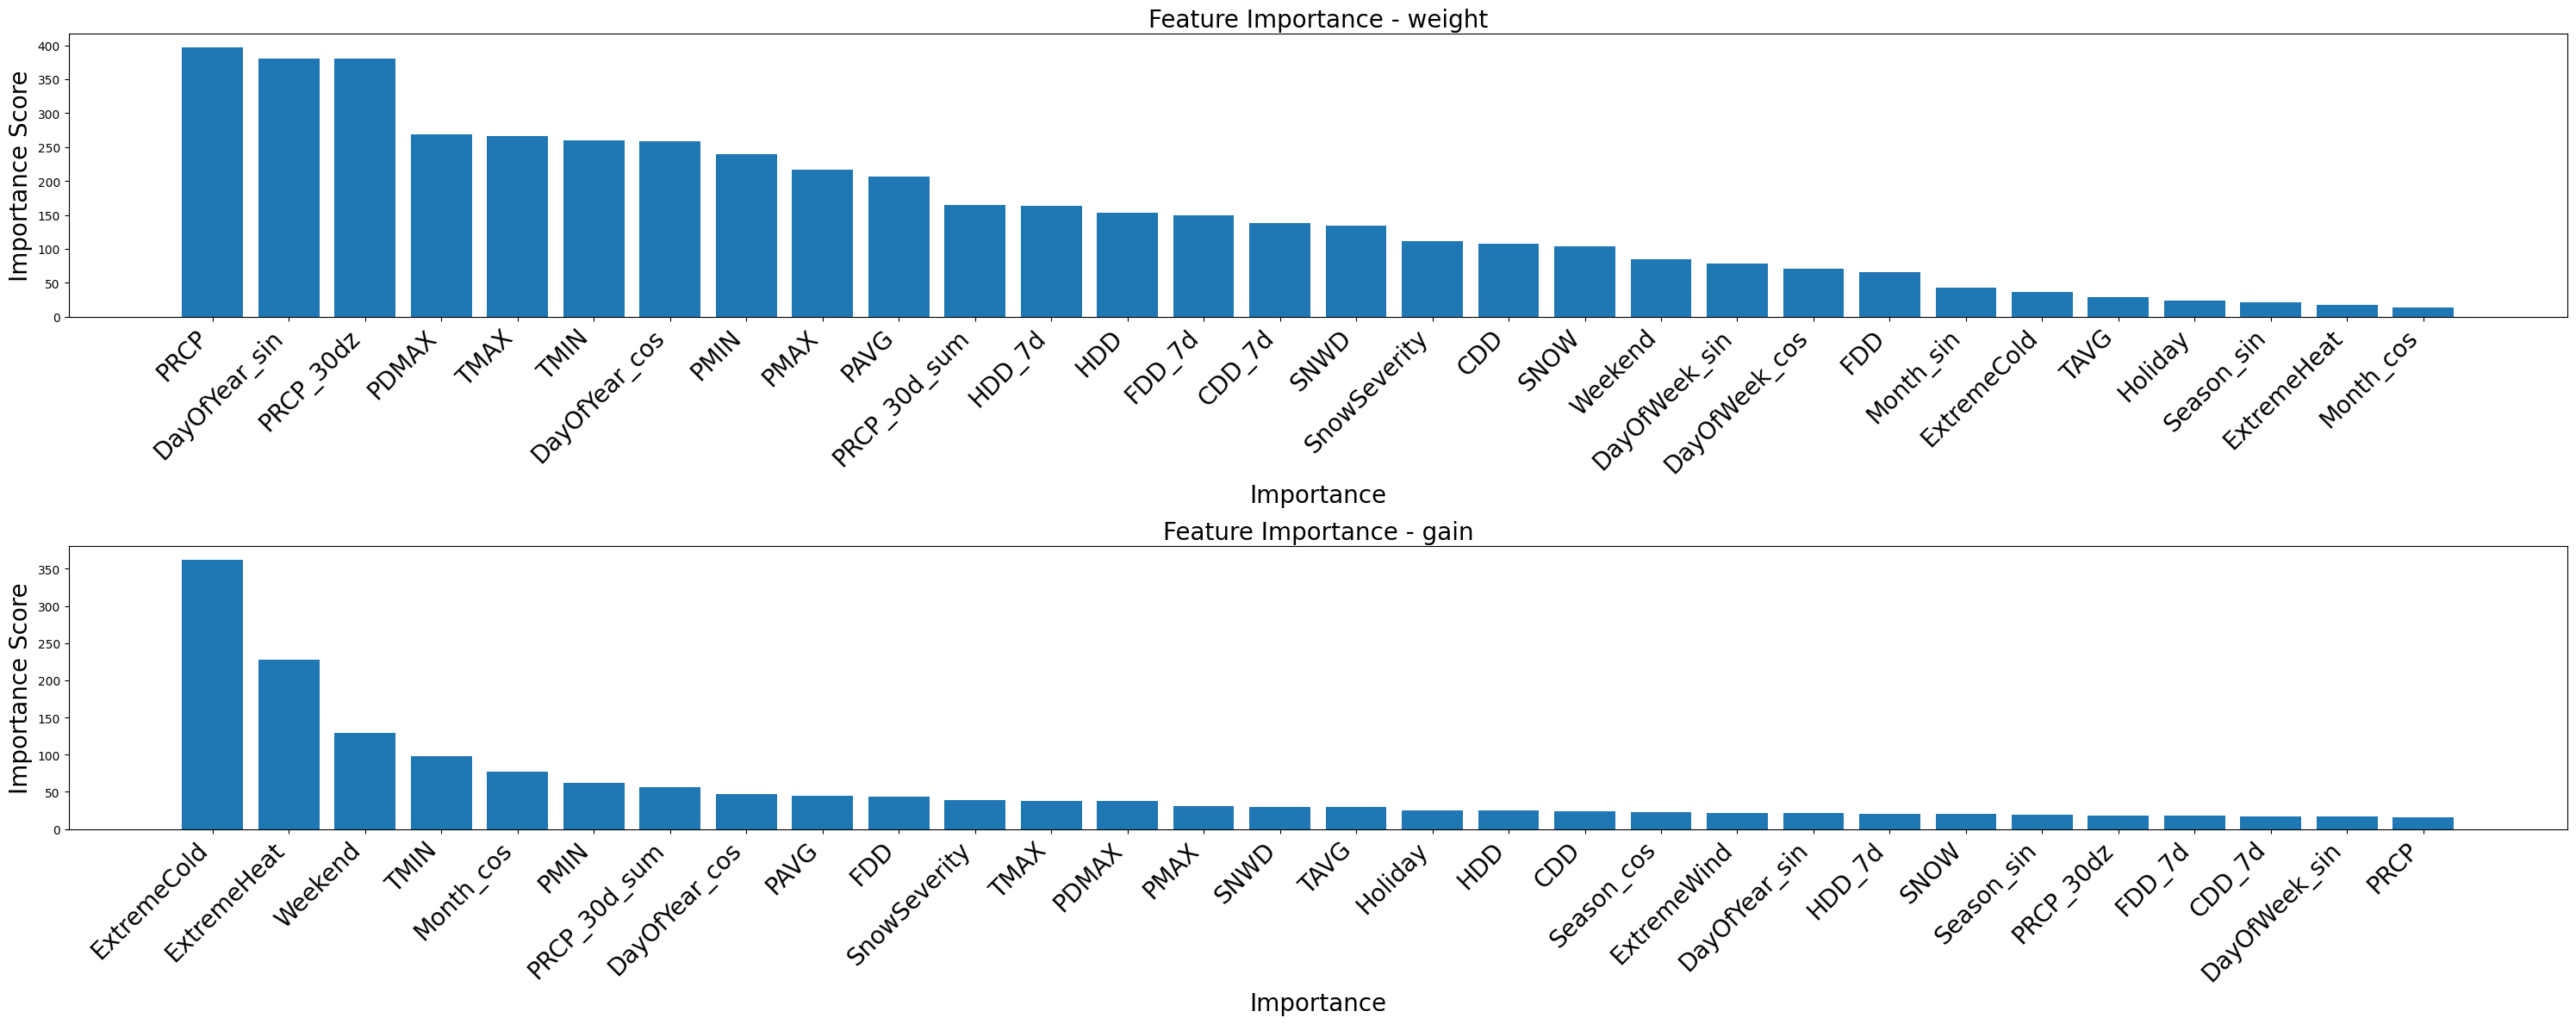

In [41]:
xgb_model.plotFeatureImportance(n_features=30, importance_criterions=['weight', 'gain'], exclude_states=True)

In [42]:
xgb_model.test_data

,ExtremeHeat,PRCP,ExtremeWind,PRCP_30dz,FDD_7d,PMIN,SNWD,Holiday,PAVG,PMAX,...,Season_sin,Season_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,C_0,Data_weight
122035,0.0,0.155801,0.0,-0.694917,3.379874,0.048842,131.222222,0.0,0.054692,0.060010,...,-2.449294e-16,1.0,0.000000e+00,1.0,0.866025,0.5,1.721336e-02,0.999852,0.000000,50.0
122036,0.0,0.121374,0.0,-1.344712,0.000000,0.022505,0.000000,0.0,0.024786,0.027033,...,-2.449294e-16,1.0,0.000000e+00,1.0,0.866025,0.5,1.721336e-02,0.999852,0.000000,29.0
122037,0.0,1.590453,0.0,0.790937,0.000000,0.007707,73.739394,0.0,0.009223,0.010576,...,-2.449294e-16,1.0,0.000000e+00,1.0,0.866025,0.5,1.721336e-02,0.999852,0.008929,224.0
122038,0.0,0.014325,0.0,-0.877048,42.286265,0.091315,143.853132,0.0,0.101235,0.111798,...,-2.449294e-16,1.0,0.000000e+00,1.0,0.866025,0.5,1.721336e-02,0.999852,0.015873,63.0
122039,0.0,0.028852,0.0,-0.248658,0.000000,0.011298,0.000000,0.0,0.012682,0.014869,...,-2.449294e-16,1.0,0.000000e+00,1.0,0.866025,0.5,1.721336e-02,0.999852,0.000000,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135589,0.0,0.041041,0.0,-0.908648,11.487500,0.511103,24.628141,0.0,0.576868,0.629175,...,-2.449294e-16,1.0,-1.133108e-15,1.0,0.866025,0.5,6.432491e-16,1.000000,0.024390,41.0
135590,0.0,0.012500,0.0,0.469218,0.000000,0.004572,0.000000,0.0,0.005194,0.005753,...,-2.449294e-16,1.0,-1.133108e-15,1.0,0.866025,0.5,6.432491e-16,1.000000,0.000000,46.0
135591,0.0,1.016095,0.0,-0.597377,17.715754,0.087588,264.978571,0.0,0.099219,0.106732,...,-2.449294e-16,1.0,-1.133108e-15,1.0,0.866025,0.5,6.432491e-16,1.000000,0.000000,6.0
135592,0.0,1.594977,0.0,0.384334,0.000000,0.000098,0.000000,0.0,0.000109,0.000120,...,-2.449294e-16,1.0,-1.133108e-15,1.0,0.866025,0.5,6.432491e-16,1.000000,0.000000,51.0


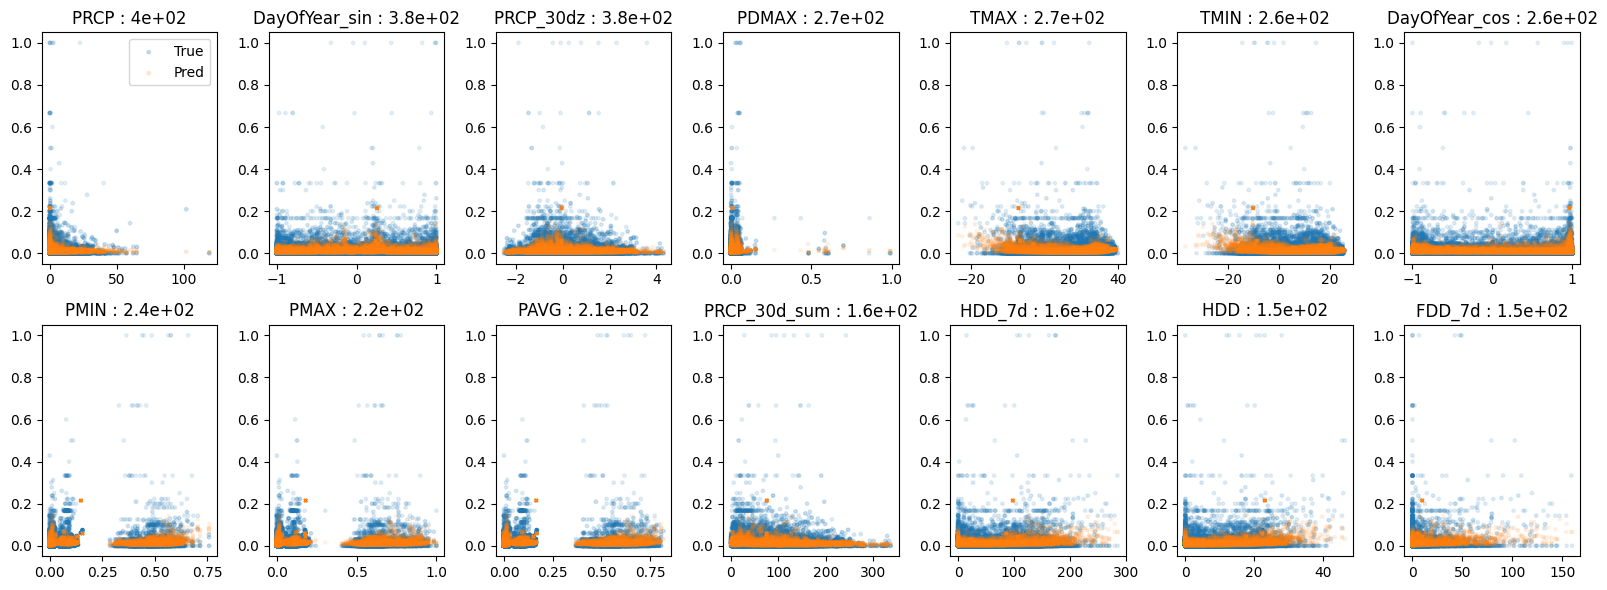

In [43]:
xgb_model.plot_feature_mapping(max_features=14, n_width=7)

## MLP

In [ ]:
importlib.reload(im)

mlp = im.MLP(verbose=True)
mlp.build_model(feature_cols=feature_names_freq, target_cols=target_columns_freq,
                hidden_sizes=[100, 100, 100, 50], activations=['relu', 'relu', 'relu', 'relu'], out_act_fn='sigmoid')

mlp.prepare_data(merged_freq_df, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, standardize=stand_cols_freq)

mlp.train_model(optimizer='adam', loss_fn='logloss',
                regularization_type='L2', lambda_reg=1e-3,
                weights_data=True,
                epochs=10, batch_size=200, lr=2e-4, device='cpu')

Sequential(
  (linear_0): Linear(in_features=79, out_features=100, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=100, out_features=100, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (activation_3): ReLU()
  (linear_out): Linear(in_features=50, out_features=1, bias=True)
  (out_activation): Sigmoid()
)
Input dim: 79 | Output dim: 1 | Trainable params: 33,301


TypeError: MLP.train_model() got an unexpected keyword argument 'loss_fn'

: 

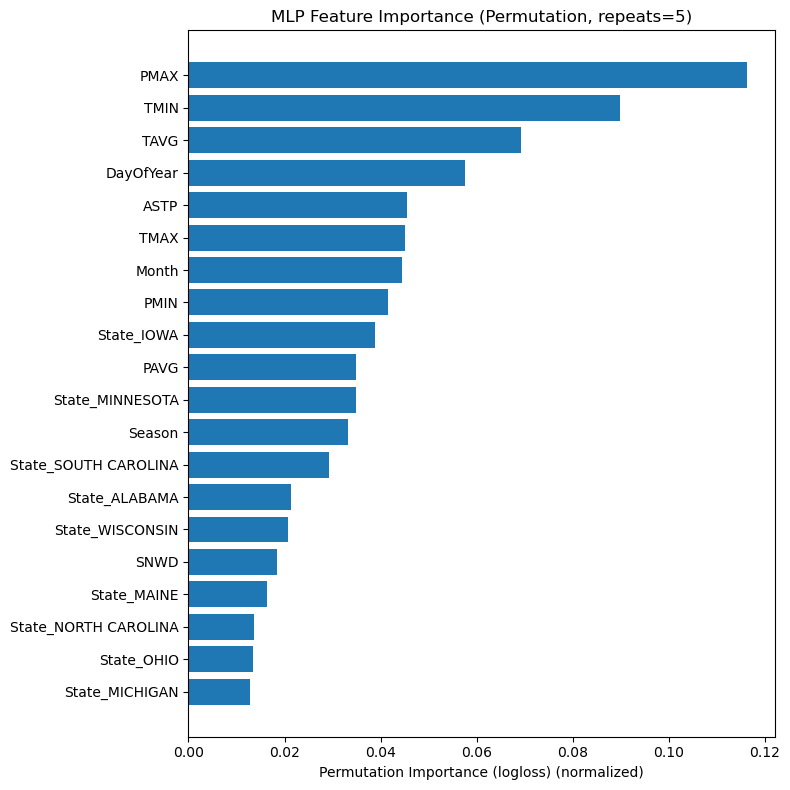

     Feature  Importance
0       PMAX    0.116265
1       TMIN    0.089859
2       TAVG    0.069244
3  DayOfYear    0.057494
4       ASTP    0.045414


In [ ]:
imp_perm = mlp.plot_feature_importance(
    method="permutation", n_repeats=5, loss="logloss", top_k=20, return_df=True
)
print(imp_perm.head())

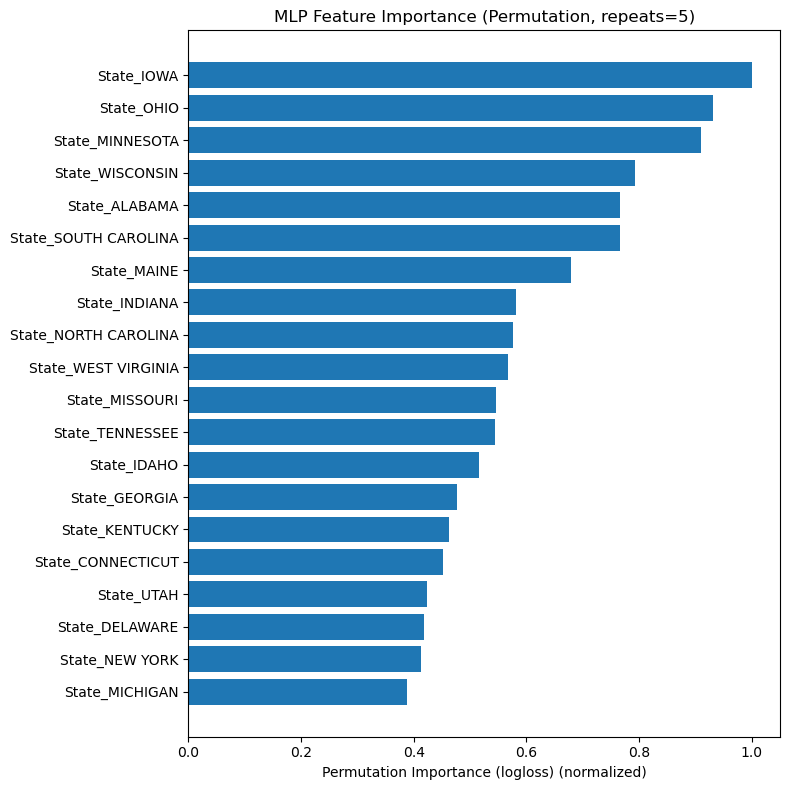

           Feature  Importance
0       State_IOWA    1.000000
1       State_OHIO    0.931256
2  State_MINNESOTA    0.910194
3  State_WISCONSIN    0.793457
4    State_ALABAMA    0.766854


In [ ]:

# 2) Gradient saliency (fast proxy)
imp_grad = mlp.plot_feature_importance(
    method="gradient", top_k=20, return_df=True
)
print(imp_grad.head())

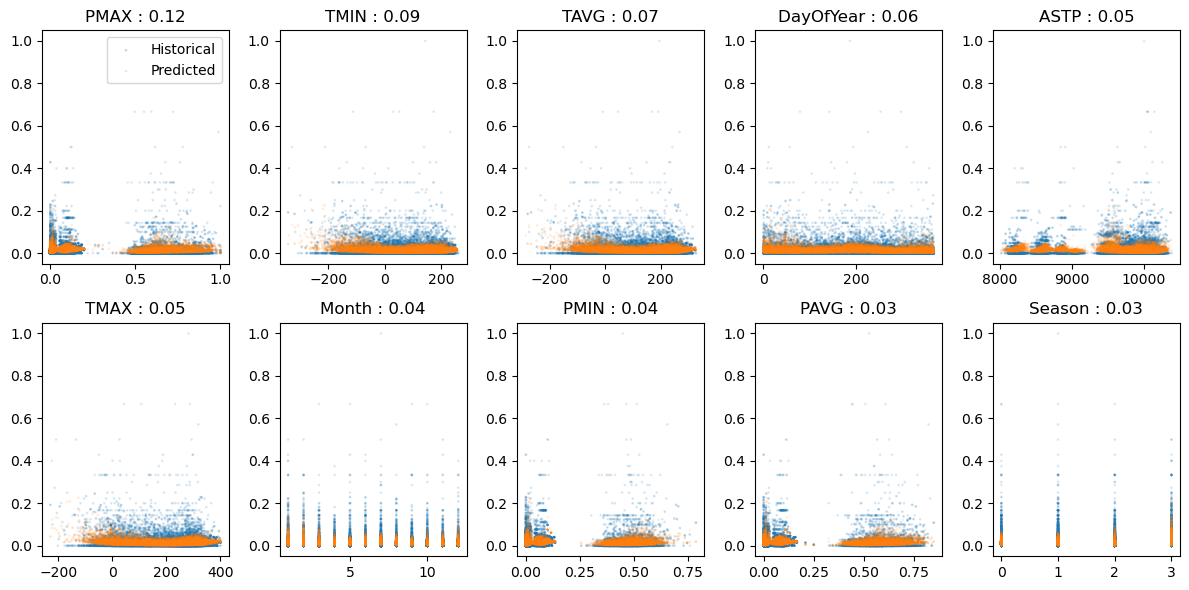

In [74]:
mlp.plot_feature_mapping()

## Logistic regression

In [4]:
clf = LogisticRegression(max_iter=100, random_state=0, verbose=True)


In [9]:
train_data = merged_count_df.iloc[:int(0.8*len(merged_count_df))]
val_data = merged_count_df.iloc[int(0.8*len(merged_count_df)):]
X_train = train_data[feature_names].to_numpy()
y_train = train_data[target_columns].to_numpy().reshape(-1,)
X_val = val_data[feature_names].to_numpy()
y_val = val_data[target_columns].to_numpy().reshape(-1,)

In [10]:
clf.fit(X_train, y_train)

/opt/miniconda3/envs/ScenarioSimulation/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [18]:
preds = clf.predict_proba(X_val)[:,1]

In [20]:
preds.max()

np.float64(0.1327737595196925)